In [1]:
## U-Net architecture in Tensorflow's Keras API
## to remove foreground from cosmological simulations
## of 21cm observations
## by Lachlan Lancaster


## Import the required Libraries
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

1.14.0


In [4]:
## Build the Model:

## Start with inputs
inputs = keras.layers.Input(shape=(64,64,30),name="image_input")

## First Convolutional layer made up of two convolutions, the second one down-samples
conv1a = keras.layers.Conv2D(64,16,activation=tf.nn.relu,name="conv1a",padding="same")(inputs)
conv1b = keras.layers.Conv2D(64,8,activation=tf.nn.relu,name="conv1b",padding="same",strides=2)(conv1a)
## Second convolutional layer, essentially identical, increases the number of channels
conv2a = keras.layers.Conv2D(128,8,activation=tf.nn.relu,name="conv2a",padding="same")(conv1b)
conv2b = keras.layers.Conv2D(128,4,activation=tf.nn.relu,name="conv2b",padding="same",strides=2)(conv2a)
## Third, continuing logically from above
conv3a = keras.layers.Conv2D(256,4,activation=tf.nn.relu,name="conv3a",padding="same")(conv2b)
conv3b = keras.layers.Conv2D(256,4,activation=tf.nn.relu,name="conv3b",padding="same",strides=2)(conv3a)
## Fourth, again, continuing logically from above
conv4a = keras.layers.Conv2D(512,4,activation=tf.nn.relu,name="conv4a",padding="same")(conv3b)
conv4b = keras.layers.Conv2D(512,4,activation=tf.nn.relu,name="conv4b",padding="same",strides=2)(conv4a)
## symmetric upsampling path with concatenation from down-sampling 
upconv1a = keras.layers.Conv2DTranspose(512,4,activation=tf.nn.relu,padding="same",name="upconv1a")(conv4b)
upconv1b = keras.layers.Conv2DTranspose(512,4,activation=tf.nn.relu,padding="same",name="upconv1b",strides=2)(upconv1a)
## The up-convolution is then concatenated with the output from "across the U" and passed along
concat1 = keras.layers.concatenate([conv4a,upconv1b],name="concat1")
## Second set of up-convolutions
upconv2a = keras.layers.Conv2DTranspose(256,4,activation=tf.nn.relu,padding="same",name="upconv2a")(concat1)
upconv2b = keras.layers.Conv2DTranspose(256,4,activation=tf.nn.relu,padding="same",name="upconv2b",strides=2)(upconv2a)
concat2 = keras.layers.concatenate([conv3a,upconv2b],name="concat2")
## Third set
upconv3a = keras.layers.Conv2DTranspose(128,4,activation=tf.nn.relu,padding="same",name="upconv3a")(concat2)
upconv3b = keras.layers.Conv2DTranspose(128,8,activation=tf.nn.relu,padding="same",name="upconv3b",strides=2)(upconv3a)
concat3 =  keras.layers.concatenate([conv2a,upconv3b],name="concat3")
## Fourth set, so the "U" has 4 layers 
upconv4a = keras.layers.Conv2DTranspose(64,8,activation=tf.nn.relu,padding="same",name="upconv4a")(concat3)
upconv4b = keras.layers.Conv2DTranspose(64,16,activation=tf.nn.relu,padding="same",name="upconv4b",strides=2)(upconv4a)
concat4 =  keras.layers.concatenate([conv1a,upconv4b],name="concat4")

## Output is then put in to a shape to match the original data
output = keras.layers.Conv2DTranspose(30,1,padding="same",name="output")(concat4)

## Compile the model
model = keras.models.Model(inputs=inputs,outputs=output)

In [5]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 64, 64, 30)] 0                                            
__________________________________________________________________________________________________
conv1a (Conv2D)                 (None, 64, 64, 64)   491584      image_input[0][0]                
__________________________________________________________________________________________________
conv1b (Conv2D)                 (None, 32, 32, 64)   262208      conv1a[0][0]                     
__________________________________________________________________________________________________
conv2a (Conv2D)                 (None, 32, 32, 128)  524416      conv1b[0][0]                     
____________________________________________________________________________________________

In [60]:
## If you've previously trained a model and have saved the trained weights 
## this is where you can load them up

#model.load_weights("./model_v100_lr-5_tl2off")

In [8]:
## Load up the data for training this is the "x" of the f(x) = y that we're training
data = np.load("data.npy")

In [5]:
## Load up the cosmological signal, this is the "y" in f(x) = y
signal = np.load("cosmo.npy")

In [7]:
## Check that everything is in the format that you expect it to be in
print (data.shape,signal.shape)

(19200, 64, 64, 30) (19200, 64, 64, 30)


In [9]:
## Split your data in to training, validation, and testing sets
(N,M) = (18000,-192)
x_train = data[:N]
y_train = signal[:N]
x_val = data[N:M]
y_val = signal[N:M]
x_test = data[M:]
y_test = signal[M:]

In [ ]:
## Train the model
N_EPOCHS = 20
N_BATCH = 64
history = model.fit(x_train,y_train,batch_size=N_BATCH,epochs=N_EPOCHS,validation_data=(x_val, y_val))

# Save the results of the training
model.save_weights("./model")

In [61]:
## Evaluate the Model, if you haven't trained the model, it should do pretty poorly!! But it should still work
y_pred = model.predict(x_test)

In [63]:
## Save the predictions that you made
#np.save("../test_pred",y_pred)

In [83]:
np.savetxt("../dev.txt",np.array([ts1,ts2]).T)

In [75]:
xval_c1 = x_test.transpose()[15].transpose()
yval_c1 = y_test.transpose()[15].transpose()
y_c1_pred = y_pred.transpose()[15].transpose()

In [79]:
plt.rc('font', **{'size': 10, 'sans-serif': ['Helvetica'], 'family': 'sans-serif'})                                          
plt.rc("text.latex", preamble=["\\usepackage{helvet}\\usepackage[T1]{fontenc}\\usepackage{sfmath}"])
plt.rc("text", usetex=True)
plt.rc('ps', usedistiller='xpdf')
plt.rc('savefig', **{'dpi': 300})

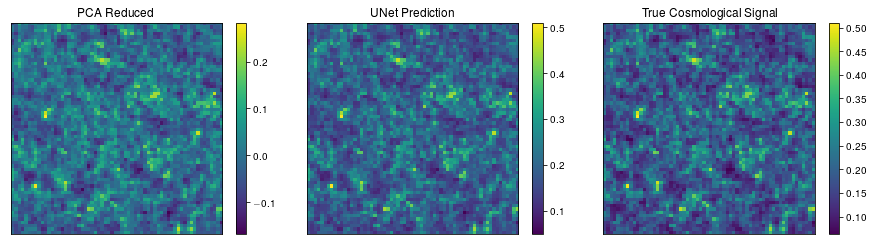

In [82]:
fig = plt.figure(figsize=(16,4))
pick = 2
ax1 = plt.subplot(131)
plt.imshow(xval_c1[pick])
plt.colorbar()
ax1.set_xticks([])
ax1.set_yticks([])
plt.title("PCA Reduced")
ax1 = plt.subplot(132)
plt.imshow(y_c1_pred[pick])
plt.colorbar()
ax1.set_xticks([])
ax1.set_yticks([])
plt.title("UNet Prediction")
ax1 = plt.subplot(133)
plt.imshow(yval_c1[pick])
plt.colorbar()
ax1.set_xticks([])
ax1.set_yticks([])
plt.title("True Cosmological Signal")
plt.gcf().set_size_inches((3.7* 3.37, 3.37))
plt.tight_layout()
plt.savefig("../../Figures/comparison.png")

In [23]:
from scipy import fftpack

(64, 64)


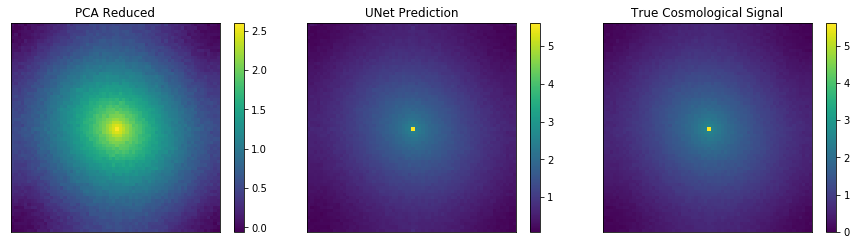

In [112]:
nui = 20
(psd2D_true,psd2D_PCA,psd2D_NN) = (np.zeros((64,64)),np.zeros((64,64)),np.zeros((64,64)))

for k in range(200):
    F1 = fftpack.fft2(y_test[k].T[nui].T)
    F2 = fftpack.fftshift( F1 )
    psd2D_true += (np.abs( F2 )**2)/200
    F1 = fftpack.fft2(x_test[k].T[nui].T)
    F2 = fftpack.fftshift( F1 )
    psd2D_PCA += (np.abs( F2 )**2)/200
    F1 = fftpack.fft2(y_pred[k].T[nui].T)
    F2 = fftpack.fftshift( F1 )
    psd2D_NN += (np.abs( F2 )**2)/200

fig = plt.figure(figsize=(16,4))
pick = 123
ax1 = plt.subplot(131)
plt.imshow(np.log10(psd2D_PCA))
plt.colorbar()
ax1.set_xticks([])
ax1.set_yticks([])
plt.title("PCA Reduced")
ax1 = plt.subplot(132)
plt.imshow(np.log10(psd2D_NN))
plt.colorbar()
ax1.set_xticks([])
ax1.set_yticks([])
plt.title("UNet Prediction")
ax1 = plt.subplot(133)
plt.imshow(np.log10(psd2D_true))
plt.colorbar()
ax1.set_xticks([])
ax1.set_yticks([])
plt.title("True Cosmological Signal")
plt.gcf().set_size_inches((3.7* 3.37, 3.37))
plt.tight_layout()
print (psd2D_true.shape)

In [113]:
(x) = (np.arange(64)-32)
(xg,yg) = np.meshgrid(x,x)
R = np.sqrt(xg**2 + yg**2).flatten()
psdf_true = psd2D_true.flatten()
psdf_NN = psd2D_NN.flatten()
psdf_PCA = psd2D_PCA.flatten()
cuts = np.array([0,4,8,12,16,20,24,28,32,36,40,44,48])
(outd,outP_true,outP_NN,outP_PCA) = ([],[],[],[])
for i in range(len(cuts)-1):
    selecs = np.intersect1d(np.where(R<cuts[i+1]),np.where(R>cuts[i]))
    outd.append(np.sum(R[selecs])/len(selecs))
    outP_true.append(np.sum(psdf_true[selecs])/len(selecs))
    outP_NN.append(np.sum(psdf_NN[selecs])/len(selecs))
    outP_PCA.append(np.sum(psdf_PCA[selecs])/len(selecs))
(outd,outP_true,outP_NN,outP_PCA) = (np.array(outd),np.array(outP_true),np.array(outP_NN),np.array(outP_PCA))

In [114]:
import healpy as hp
theta = outd*(hp.nside2resol(4)*(180/np.pi)/64)

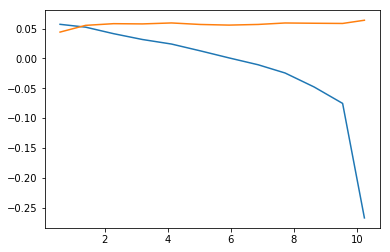

In [116]:
plt.plot(theta,np.log10(outP_true)-np.log10(outP_NN))
plt.plot(theta,np.log10(outP_true)-np.log10(outP_PCA))
#np.savetxt("powspec.txt",np.array([theta,outP_true,outP_NN,outP_PCA]).T)

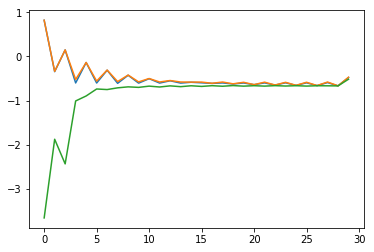

In [47]:
y_pred_flat = np.reshape(y_pred,(200*64*64,30))
ps_pred = np.sum(np.array([np.abs(fftpack.rfft(j)) for j in y_pred_flat]),axis=0)/(200*64*64)
y_test_flat = np.reshape(y_test,(200*64*64,30))
ps_true = np.sum(np.array([np.abs(fftpack.rfft(j)) for j in y_test_flat]),axis=0)/(200*64*64)
x_test_flat = np.reshape(x_test,(200*64*64,30))
ps_pca = np.sum(np.array([np.abs(fftpack.rfft(j)) for j in x_test_flat]),axis=0)/(200*64*64)

plt.plot(np.log10(ps_pred))
plt.plot(np.log10(ps_true))
plt.plot(np.log10(ps_pca))
plt.show()